In [25]:
import csv
import re
import json
import matplotlib
import seaborn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import style, colors
# import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import gridspec
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata, leaves_list
from scipy.spatial.distance import pdist
import numpy as np
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


# matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to enable jupyter ipython widgets run following line at command line
# jupyter nbextension enable --py widgetsnbextension
# to import ipywidgets in jupyter notebook
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


# constants

In [27]:
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/'
patients_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/118_patients.txt'
colormap_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps.txt'
legend_cmap = '/projects/trans_scratch/validations/workspace/szong/Cervical/color_maps_for_legend.txt'
# mutation_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details.txt'
# mutation_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/mutsig2cv/118_patients/smgs_reviewed_details_with_frequency_20190326.txt'
# codingmut_rate_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/coding_mutation_rate.txt.20190104'
mut_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/strelka_HML_summary_20190527.txt'
apobec_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/other/master_patient_table_20180813_123samples_all_from_Reanne.txt'
# covariate_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/HTMCP_covariates_final_20190325.txt'
covariate_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/HTMCP_covariates_final_20190619.txt'
hrd_f = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/hrd_scores.txt'

In [28]:
pats = pd.read_csv(patients_f, header=None)[0].tolist()
len(pats)

118

In [29]:
# Read all the annotations
ann = json.loads(open('/gsc/pipelines/mavis/reference_files/ensembl69_hg19_annotations.json').read())

# For each gene, only keep the 'best_transcript' of  those with 'aliases' (hugo names)
lst = []
for g in ann['genes']:
    for transcript in g['transcripts']:
        if g['aliases'] and transcript['is_best_transcript']:
            lst.append((g['name'], g['aliases'], transcript['name'])) 
            
best_transcripts = [i[2] for i in lst]

len(best_transcripts)

19616

In [73]:
btrans = pd.DataFrame(best_transcripts)
btrans.columns = ['best_transcript']
btrans[:3]
of = '/home/szong/projects/resource/best_transcripts_20190617.txt'
# btrans.to_csv(of, index=False)

,best_transcript
0,ENST00000381700
1,ENST00000445946
2,ENST00000420022


# 1. functions

In [12]:
def format_impact(impact):
    impact = impact.upper()
    if '+' in impact:
        impact = impact.split('+')[0]
    return impact

In [75]:
def sort_patients(dfxx):
    # exhausitive binary sort
    i = 1e22
    arr = []
    for ix, row in dfxx.iterrows():
        arr.append(row * i)
#         print(i)
        i = i/10
    sorted_pats = pd.DataFrame(arr).sum().sort_values(ascending=False).index.tolist()
#     print(pd.DataFrame(arr).sum().sort_values(ascending=False))
    return sorted_pats

In [76]:
def impact_type(x):
#     print(x)
    xsplit = x.split(',')
#     print(x)
#     type = xsplit[0].upper()
    if len(xsplit) > 1:
        type = 'Multi_hit'
    elif len(xsplit) == 1:
        type = xsplit[0]
        if type == 'MISSENSE_VARIANT' or type == 'NON_SYNONYMOUS_CODING':
           type = 'Non-synonymous'
        elif type == 'SYNONYMOUS_VARIANT' or type == 'SYNONYMOUS_CODING':
           type = 'Synonymous'
        elif  type == 'SPLICE_SITE_ACCEPTOR' or  type == 'SPLICE_SITE_DONOR' or type == 'SPLICE_SITE_REGION':
           type = 'Splice site'
        elif type == 'STOP_LOST':
           type = 'Stop lost'
        elif type == 'STOP_GAINED':
           type = 'Stop gained'
        elif  type == 'START_LOST':
           type = 'Start lost'
        elif type == 'START_GAINED':
           type = 'Start gained'
        elif type == 'FRAME_SHIFT' or type == 'FRAMESHIFT_VARIANT':
           type = 'Frameshift'
        elif type == 'INFRAME_DELETION' or type == 'CODON_INSERTION' or type == 'CODON_DELETION' or type == 'CODON_CHANGE_PLUS_CODON_INSERTION' or type == 'CODON_CHANGE_PLUS_CODON_DELETION' or type.lower() == 'disruptive_inframe_deletion':
           type = 'Codon indel'                
        else: exit(1);print('ERROR');print(x)
    return type

In [77]:
def plot_mutation_heatmap(ax, df, map_dict, cmap):
    df = df.apply(lambda x: x.map(map_dict)).astype(float)
    sns.heatmap(df, 
                ax=ax, 
                cmap=cmap,
                linewidths=.05,                    
                xticklabels=True,
                yticklabels=True,
                cbar=False) #cbar_ax=ax1,
#     _ = ax.tick_params(axis='y', which='major', labelsize=27)
#     _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    yticklbs = ['  '.join(re.split('\(|%', str(i.get_text()))[:2]) for i in ax.get_yticklabels()]
    _ = ax.set_yticklabels(yticklbs, fontweight='bold',fontsize=20, rotation=0)
    _ = ax.tick_params(axis='y', which='major', pad=12, labelsize=22)
    _ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    _ = ax.yaxis.tick_left()
    _ = ax.set_xticklabels('')
    # _ = ax.set_yticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    # set heatmap background color, nan values will be this color
    _ = ax.set_facecolor('#f2f2f3')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)
    # set ticklabel fontname, need to add the font first, leave it out for now
#     for tick in ax.get_yticklabels():
#         tick.set_fontname("Helvetica")

    return df

In [78]:
def plot_covariate_track(ax, df, patients, map_dict_cov, cmap_cov):
    df = df[patients]
    df_mapped = df.apply(lambda x: x.map(map_dict_cov)).astype(float)
#     print(df_mapped)
    sns.heatmap(df_mapped, 
                ax=ax, 
                cmap=cmap_cov,
                linewidths=.05,                    
                xticklabels=True,
                yticklabels=True,
                cbar=False) 
    _ = ax.tick_params(axis='y', which='major', labelsize=19)
    yticklbs = [' '.join(i.get_text().upper().split('_')) for i in ax.yaxis.get_majorticklabels()]
    _ = ax.set_yticklabels(yticklbs, fontsize=20, rotation=0)
#     _ = ax.set_yticklabels(yticklbs, fontweight='bold',fontsize=20, rotation=0)
    _ = ax.tick_params(axis='x', which='major', labelsize=7)
    _ = ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    _ = ax.yaxis.tick_left()
    _ = ax.set_xticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_xticklines(),visible=False)

    return df_mapped

In [79]:
def numeric_covariate(ax, df, patients, ax2):
    df = df[patients]
    ax = sns.heatmap(df, ax=ax, cbar=True, xticklabels=False, yticklabels=True, cbar_ax=ax2, cmap="PuBu")
    # cbar controls if cbar is drawn, cbar_ax controls which ax to draw
    _ = ax.tick_params(axis='y', which='major', labelsize=19)
    _ = ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    _ = ax.set_xticklabels('')
    _ = ax.set_xlabel('')
    _ = ax.set_ylabel('')
    _ = plt.setp(ax.get_yticklines(),visible=False)
    _ = plt.setp(ax.get_yticklines(),visible=False)
#     cax = plt.gcf().axes[1]
#     cax.tick_params(labelsize=50)
#     _ = ax.set_ylabel('HRD_score', fontsize=16, rotation=0)

In [80]:
def add_patches(ax, features, column, clrmap_dict, leg_name):
    k = 0
    # add legend title
    _ = ax.text(legspace+column*xoffset, titley, leg_name, ha='center', va='center', fontsize=19)
    for feature in features:
        types = len(features)
        clr = clrmap_dict[feature]
        rect = patches.Rectangle((0+column*xoffset, yoffset-k*rowstep), .02, .05, 
                             linewidth=0.001,
                             edgecolor=clr,
                             facecolor=clr)
        
        _ = ax.text(legspace+column*xoffset, yoffset-k*rowstep+.01, 
                     feature, 
                     ha='left', 
                     va='center', 
                     fontsize=16)
        _ = ax.add_patch(rect)
        k+=1
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = ax.set_title('')


In [81]:
def sort_patients(dfxx):
    # exhausitive binary sort
    i = 1e18
    arr = []
    for ix, row in dfxx.iterrows():
        arr.append(row * i)
#         print(i)
        i = i/10
    sorted_pats = pd.DataFrame(arr).sum().sort_values(ascending=False).index.tolist()
#     print(pd.DataFrame(arr).sum().sort_values(ascending=False))
    return sorted_pats

In [82]:
def make_cmap_for_heatmap(categories, color_dict):
    '''map category types to a number and make a cmap for heatmap'''
    map_dict = {k:v for v, k in  enumerate(categories)} 
    clrs = [color_dict[m] for m in categories]
    cmap = colors.ListedColormap(clrs)
#     print('colors used:')
#     for cat, c in zip(categories, clrs):
#         print(cat, c)
#     sns.palplot(clrs)
    return (map_dict, cmap)

In [83]:
def legend_lines(clr, lb):
    return Line2D([0], [0], color=clr, lw=2, label=lb)

def make_patch(fc, ec, lb):
    return Patch(facecolor=fc, edgecolor=ec, label=lb, linewidth=2)

def remove_axes(ax):
    _ = plt.setp(ax.get_yticklines(), visible=False)
    _ = plt.setp(ax.get_xticklines(), visible=False)
    _ = ax.set_xticklabels('')

def add_legend(ax, legend_handles, title):
    _ = remove_axes(ax)
    _ = ax.set_yticklabels('')
    leg = ax.legend(handles=legend_handles, loc='upper left', fontsize=20,  
                    bbox_to_anchor=(0.02, 0.95), title=title, frameon=False,
                    handlelength=1, handleheight=1.125)
    leg.get_title().set_fontsize(18)
    leg.set_title(leg.get_title().get_text(), prop = {'size':18, 'weight':'bold'})
    leg._legend_box.align = "center"

### 1. mutations

In [30]:
mut_file

'/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/strelka_HML_summary_20190527.txt'

In [31]:
df = pd.read_csv(mut_file, sep='\t')
df.head(2)
df.shape

patients = df.patient.unique()
df.gene.nunique()

,chr,pos,ref,alt,patient,impact,impact_type,type,AA_change,gene,transcript
0,1,2706109,C,G,HTMCP-03-06-02001,SYNONYMOUS_CODING,LOW,SILENT,R16,TTC34,ENST00000401095
1,1,2706109,C,G,HTMCP-03-06-02001,SYNONYMOUS_CODING,LOW,SILENT,R16,TTC34,ENST00000574621


(102013, 11)

14557

In [32]:
f4 = '/projects/trans_scratch/validations/workspace/szong/Cervical/chipseq/categorisation_of_epigentic_modifiers_v4.xlsx'
df4 = pd.read_excel(f4, sheet_name='categorisation')
df4.head(2)
genes = df4['HIV neg'].unique()
len(genes)

,HIV neg,neg samples with mutations,HIV positive,pos samples with mutation,total,category_1,category_2,markes /regiones affected,comments
0,ARID1A,2,ARID1A,1,3,Remodeller,SWI/SNF remodeling complex,NaN,NaN
1,ATRX,4,ATRX,1,5,Remodeller,SWI/SNF family,gene bodies of ZFN genes,Binds to zinc-finger coding genes with atypica...


116

In [33]:
df1 = df[(df.gene.isin(genes))&(df.transcript.isin(best_transcripts))]
df1.shape
# i should pick the best transcript instead
df2 = df1[['patient', 'impact', 'gene']].drop_duplicates()
df2.shape
df2.head(2)

(441, 11)

(417, 3)

,patient,impact,gene
82,HTMCP-03-06-02001,NON_SYNONYMOUS_CODING,TAF5L
379,HTMCP-03-06-02001,NON_SYNONYMOUS_CODING,EZH2


mutated in coding regions, it can have high, moderate, or low impact

In [34]:
df2['mut_status'] = 'mutated' 

In [35]:
df2.head(2)

,patient,impact,gene,mut_status
82,HTMCP-03-06-02001,NON_SYNONYMOUS_CODING,TAF5L,mutated
379,HTMCP-03-06-02001,NON_SYNONYMOUS_CODING,EZH2,mutated


In [68]:
dfw = df2.pivot_table(values='mut_status', index='gene', columns='patient', aggfunc=lambda x: ''.join([str(v) for v in x][0]))

In [69]:
dfw = dfw.reindex(patients, axis=1)
dfw.shape

(104, 118)

In [74]:
dfw.notnull().sum().sort_values()

patient
HTMCP-03-06-02393     0
HTMCP-03-06-02195     0
HTMCP-03-06-02152     0
HTMCP-03-06-02151     0
HTMCP-03-06-02150     0
HTMCP-03-06-02414     0
HTMCP-03-06-02216     0
HTMCP-03-06-02235     0
HTMCP-03-06-02427     0
HTMCP-03-06-02047     0
HTMCP-03-06-02046     0
HTMCP-03-06-02217     0
HTMCP-03-06-02264     0
HTMCP-03-06-02267     0
HTMCP-03-06-02036     0
HTMCP-03-06-02434     0
HTMCP-03-06-02261     0
HTMCP-03-06-02197     1
HTMCP-03-06-02194     1
HTMCP-03-06-02333     1
HTMCP-03-06-02377     1
HTMCP-03-06-02003     1
HTMCP-03-06-02344     1
HTMCP-03-06-02008     1
HTMCP-03-06-02149     1
HTMCP-03-06-02144     1
HTMCP-03-06-02213     1
HTMCP-03-06-02125     1
HTMCP-03-06-02120     1
HTMCP-03-06-02002     1
                     ..
HTMCP-03-06-02428     4
HTMCP-03-06-02268     4
HTMCP-03-06-02442     4
HTMCP-03-06-02326     4
HTMCP-03-06-02006     4
HTMCP-03-06-02092     4
HTMCP-03-06-02176     4
HTMCP-03-06-02128     4
HTMCP-03-06-02020     4
HTMCP-03-06-02196     5
HTMCP-03

In [58]:
dff = dfw.notnull().sum(axis=1).sort_values(ascending=False).to_frame()
dff.columns = ['number_patients_mutated']
dff['percent_patients_mutated'] = dff.number_patients_mutated/118
dff.head(2)

,number_patients_mutated,percent_patients_mutated
gene,,
MLL3,26,0.220339
MLL2,17,0.144068


In [59]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/epigenetic_gene_mutations_20190904.tsv'
dff.to_csv(of, sep='\t')

In [62]:
dfw.fillna('wt',inplace=True)

In [64]:
dfw.head(2)
dfw.shape

patient,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02036,HTMCP-03-06-02037,...,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447
gene,,,,,,,,,,,,,,,,,,,,,
ARID1A,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt,...,wt,wt,wt,wt,wt,mutated,wt,wt,wt,wt
ATRX,wt,wt,wt,wt,wt,wt,mutated,wt,wt,wt,...,wt,wt,wt,wt,wt,wt,wt,wt,wt,wt


(104, 118)

In [66]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/epigenetic_gene_mutations_details_20190904.tsv'
dfw.to_csv(of, sep='\t')

In [13]:
# this deals with annotations with + signs, just pick the first one for now
df2['impact_new'] = df2['impact'].apply(format_impact)
df2.drop('impact', axis=1, inplace=True)
df2.shape
df2 = df2.drop_duplicates(keep='first')
df2.columns = ['patient', 'gene', 'impact']
df2.shape

(417, 3)

(416, 3)

In [24]:
df2.head()
df2.gene.nunique()

,patient,gene,impact
82,HTMCP-03-06-02001,TAF5L,NON_SYNONYMOUS_CODING
379,HTMCP-03-06-02001,EZH2,NON_SYNONYMOUS_CODING
416,HTMCP-03-06-02001,TAF1L,NON_SYNONYMOUS_CODING
617,HTMCP-03-06-02001,EP400,NON_SYNONYMOUS_CODING
789,HTMCP-03-06-02001,DOT1L,NON_SYNONYMOUS_CODING


104

In [22]:
df2[df2.patient.isin(pats)]['patient'].nunique()

101

In [23]:
df2.impact.value_counts()

NON_SYNONYMOUS_CODING               237
SYNONYMOUS_CODING                    81
STOP_GAINED                          39
SPLICE_SITE_REGION                   19
START_GAINED                         16
FRAME_SHIFT                          14
SPLICE_SITE_ACCEPTOR                  4
SPLICE_SITE_DONOR                     3
CODON_CHANGE_PLUS_CODON_DELETION      2
CODON_DELETION                        1
Name: impact, dtype: int64

In [88]:
df3 = pd.pivot_table(df2, index='patient', columns='gene', values='impact', aggfunc=lambda x: ','.join([str(v) for v in x])).reset_index()
df3.head(2)

df5 = pd.melt(df3, id_vars='patient', value_vars=df3.columns[1:], value_name='impact', var_name='gene').dropna()
df5.head()

df5['impact'] = df5.impact.apply(lambda x: impact_type(x))
df5.head()

df6 = pd.pivot_table(df5, index='patient', columns='gene', values='impact', aggfunc=lambda x: ','.join([str(v) for v in x]))
df6 = df6.reindex(patients)

pd.Series(df6.values.ravel()).unique()
df6 = df6.T
df6.head(2)
df6.shape

gene,patient,ARID1A,ATRX,BAZ1A,BAZ1B,BAZ2B,BRD2,BRD3,BRD4,BRD7,...,TBL1X,TFPT,TRIM33,TRRAP,UBE2B,WHSC1L1,YEATS2,YY1,ZMYND11,ZMYND8
0,HTMCP-03-06-02001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HTMCP-03-06-02002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,patient,gene,impact
18,HTMCP-03-06-02074,ARID1A,"SYNONYMOUS_CODING,NON_SYNONYMOUS_CODING"
26,HTMCP-03-06-02103,ARID1A,NON_SYNONYMOUS_CODING
66,HTMCP-03-06-02238,ARID1A,"STOP_GAINED,SYNONYMOUS_CODING"
78,HTMCP-03-06-02326,ARID1A,NON_SYNONYMOUS_CODING
82,HTMCP-03-06-02333,ARID1A,SYNONYMOUS_CODING


,patient,gene,impact
18,HTMCP-03-06-02074,ARID1A,Multi_hit
26,HTMCP-03-06-02103,ARID1A,Non-synonymous
66,HTMCP-03-06-02238,ARID1A,Multi_hit
78,HTMCP-03-06-02326,ARID1A,Non-synonymous
82,HTMCP-03-06-02333,ARID1A,Synonymous


array([nan, 'Non-synonymous', 'Codon indel', 'Stop gained', 'Multi_hit',
       'Frameshift', 'Synonymous', 'Splice site', 'Start gained'],
      dtype=object)

patient,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02036,HTMCP-03-06-02037,...,HTMCP-03-06-02417,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447
gene,,,,,,,,,,,,,,,,,,,,,
ARID1A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Non-synonymous,NaN,NaN,NaN,NaN
ATRX,NaN,NaN,NaN,NaN,NaN,NaN,Stop gained,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(104, 118)

104 epigenetic genes, 101 patients have at lease one mutation

In [89]:
df5.gene.nunique()
df5.patient.nunique()


104

101

In [90]:
top20_genes = df6.notnull().sum(axis=1).sort_values(ascending=False)[:20].index
df7 = df6[df6.index.isin(top20_genes)].reindex(top20_genes)

In [91]:
df5.shape
df5[df5.gene.isin(top20_genes)]['patient'].nunique()
df5[df5.gene.isin(top20_genes)]['gene'].nunique()

(386, 3)

77

20

In [92]:
# sort patients based on if a gene is mutated or not in the order of genes
dfz = df7.notnull()
sorted_pats = sort_patients(dfz)
df7 = df7[sorted_pats]
df7.head(2)

patient,HTMCP-03-06-02214,HTMCP-03-06-02435,HTMCP-03-06-02097,HTMCP-03-06-02042,HTMCP-03-06-02058,HTMCP-03-06-02001,HTMCP-03-06-02128,HTMCP-03-06-02210,HTMCP-03-06-02185,HTMCP-03-06-02098,...,HTMCP-03-06-02149,HTMCP-03-06-02261,HTMCP-03-06-02144,HTMCP-03-06-02264,HTMCP-03-06-02125,HTMCP-03-06-02213,HTMCP-03-06-02110,HTMCP-03-06-02108,HTMCP-03-06-02267,HTMCP-03-06-02377
gene,,,,,,,,,,,,,,,,,,,,,
MLL3,Multi_hit,Multi_hit,Frameshift,Splice site,Non-synonymous,Codon indel,Stop gained,Multi_hit,Non-synonymous,Stop gained,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MLL2,Multi_hit,Frameshift,Multi_hit,Stop gained,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. color scheme

In [93]:
df_clrs = pd.read_csv(legend_cmap, sep='\t', header=None)
leg_colors = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
# leg_colors

,0,1
0,Negative,#d9d9d9
1,Positive,#000000


('Negative', '#d9d9d9')

33    HPV31
34    HPV33
35    HPV35
36    HPV52
37    HPV58
38    HPV18
39    HPV45
40    HPV68
41    HPV59
42    HPV82
43    HPV51
44     HPV9
45    HPV69
46    HPV30
47    HPV26
Name: 0, dtype: object

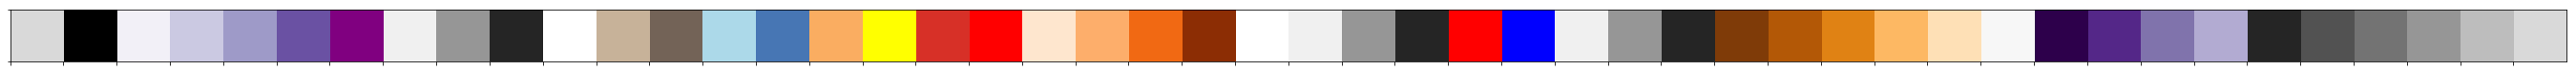

In [94]:
# choose color from here
# http://colorbrewer2.org/#type=diverging&scheme=RdYlBu&n=4

df_clrs = pd.read_csv(colormap_f, sep='\t', header=None)
color_dict = pd.Series(df_clrs[1].values,index=df_clrs[0]).to_dict()
df_clrs.head(2)
list(color_dict.items())[0]
sns.palplot(df_clrs[1][:])
df_clrs[0][-15:]

### 3. covariates

In [95]:
df_cov = pd.read_csv(covariate_f, sep='\t', index_col='patient')
df_cov.head()

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
patient,,,,,,,,,,,,,,,,,,,,,
tumor_grade,G2,unknown,G3,G3,unknown,G2,unknown,G3,G2,G2,...,G2,unknown,G1,G3,unknown,G2,G3,unknown,G3,G3
age_at_diagnosis,<45,45-65,<45,<45,<45,45-65,<45,45-65,<45,45-65,...,<45,45-65,<45,>65,45-65,45-65,45-65,unknown,<45,>65
clinical_stage,Stage I,Stage II,Stage IV,Stage I,Stage II,Stage II,Stage I,Stage III,Stage I,Stage III,...,Stage III,Stage II,Stage II,Stage II,Stage IV,Stage III,Stage II,unknown,Stage II,Stage III
APOBEC_signature,>0.4,>0.4,<0.2,0.2-0.4,0.2-0.4,0.2-0.4,0.2-0.4,>0.4,0.2-0.4,0.2-0.4,...,>0.4,<0.2,<0.2,0.2-0.4,0.2-0.4,<0.2,<0.2,<0.2,<0.2,<0.2
HIV_status,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative


In [96]:
df_cov = df_cov.drop('tumor_grade')
df_cov

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
patient,,,,,,,,,,,,,,,,,,,,,
age_at_diagnosis,<45,45-65,<45,<45,<45,45-65,<45,45-65,<45,45-65,...,<45,45-65,<45,>65,45-65,45-65,45-65,unknown,<45,>65
clinical_stage,Stage I,Stage II,Stage IV,Stage I,Stage II,Stage II,Stage I,Stage III,Stage I,Stage III,...,Stage III,Stage II,Stage II,Stage II,Stage IV,Stage III,Stage II,unknown,Stage II,Stage III
APOBEC_signature,>0.4,>0.4,<0.2,0.2-0.4,0.2-0.4,0.2-0.4,0.2-0.4,>0.4,0.2-0.4,0.2-0.4,...,>0.4,<0.2,<0.2,0.2-0.4,0.2-0.4,<0.2,<0.2,<0.2,<0.2,<0.2
HIV_status,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Putative_histology,Squamous,Squamous,Adenocarcinoma,Squamous,Squamous,Squamous,Adenosquamous,Squamous,Squamous,Squamous,...,Adenosquamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous


In [97]:
df_cov = df_cov.T.rename(columns={'Putative_histology':'Histology', 'clinical_stage': 'Clinical_stage', 'age_at_diagnosis': 'Age_at_diagnosis'}).T

In [98]:
df_cov = df_cov.loc[['HIV_status', 'Histology', 'APOBEC_signature',  'Clinical_stage', 'Age_at_diagnosis' ]]

In [99]:
df_cov

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
patient,,,,,,,,,,,,,,,,,,,,,
HIV_status,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Histology,Squamous,Squamous,Adenocarcinoma,Squamous,Squamous,Squamous,Adenosquamous,Squamous,Squamous,Squamous,...,Adenosquamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
APOBEC_signature,>0.4,>0.4,<0.2,0.2-0.4,0.2-0.4,0.2-0.4,0.2-0.4,>0.4,0.2-0.4,0.2-0.4,...,>0.4,<0.2,<0.2,0.2-0.4,0.2-0.4,<0.2,<0.2,<0.2,<0.2,<0.2
Clinical_stage,Stage I,Stage II,Stage IV,Stage I,Stage II,Stage II,Stage I,Stage III,Stage I,Stage III,...,Stage III,Stage II,Stage II,Stage II,Stage IV,Stage III,Stage II,unknown,Stage II,Stage III
Age_at_diagnosis,<45,45-65,<45,<45,<45,45-65,<45,45-65,<45,45-65,...,<45,45-65,<45,>65,45-65,45-65,45-65,unknown,<45,>65


#### HRD scores

In [100]:
hrd = pd.read_csv(hrd_f, sep='\t')
hrd = hrd[['sample_id', 'HRD']].set_index('sample_id')
bins = [-1, 10, 30, 60]
labels = ['<=10', '10-30', '>30']

hrd['HRD'] = pd.cut(hrd['HRD'], right=True, bins=bins, labels=labels)
hrd = hrd.T
hrd.head(2)

sample_id,HTMCP-03-06-02001,HTMCP-03-06-02002,HTMCP-03-06-02003,HTMCP-03-06-02006,HTMCP-03-06-02007,HTMCP-03-06-02008,HTMCP-03-06-02012,HTMCP-03-06-02013,HTMCP-03-06-02020,HTMCP-03-06-02026,...,HTMCP-03-06-02424,HTMCP-03-06-02427,HTMCP-03-06-02428,HTMCP-03-06-02434,HTMCP-03-06-02435,HTMCP-03-06-02437,HTMCP-03-06-02441,HTMCP-03-06-02442,HTMCP-03-06-02447,HTMCP-03-06-02448
HRD,<=10,<=10,>30,>30,<=10,<=10,<=10,10-30,10-30,<=10,...,10-30,10-30,10-30,10-30,<=10,10-30,10-30,<=10,>30,<=10


In [101]:
df_cov

,HTMCP-03-06-02260,HTMCP-03-06-02428,HTMCP-03-06-02139,HTMCP-03-06-02240,HTMCP-03-06-02262,HTMCP-03-06-02001,HTMCP-03-06-02411,HTMCP-03-06-02070,HTMCP-03-06-02148,HTMCP-03-06-02346,...,HTMCP-03-06-02326,HTMCP-03-06-02194,HTMCP-03-06-02046,HTMCP-03-06-02156,HTMCP-03-06-02332,HTMCP-03-06-02008,HTMCP-03-06-02197,HTMCP-03-06-02222,HTMCP-03-06-02185,HTMCP-03-06-02037
patient,,,,,,,,,,,,,,,,,,,,,
HIV_status,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative
Histology,Squamous,Squamous,Adenocarcinoma,Squamous,Squamous,Squamous,Adenosquamous,Squamous,Squamous,Squamous,...,Adenosquamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous,Squamous
APOBEC_signature,>0.4,>0.4,<0.2,0.2-0.4,0.2-0.4,0.2-0.4,0.2-0.4,>0.4,0.2-0.4,0.2-0.4,...,>0.4,<0.2,<0.2,0.2-0.4,0.2-0.4,<0.2,<0.2,<0.2,<0.2,<0.2
Clinical_stage,Stage I,Stage II,Stage IV,Stage I,Stage II,Stage II,Stage I,Stage III,Stage I,Stage III,...,Stage III,Stage II,Stage II,Stage II,Stage IV,Stage III,Stage II,unknown,Stage II,Stage III
Age_at_diagnosis,<45,45-65,<45,<45,<45,45-65,<45,45-65,<45,45-65,...,<45,45-65,<45,>65,45-65,45-65,45-65,unknown,<45,>65


In [102]:
df_cov = pd.concat([df_cov, hrd], sort=False)

In [103]:

df_cov = df_cov[sorted_pats]
assert df_cov.shape[1] == 118
df_cov.shape

(6, 118)

In [104]:
color_dict

{'Negative': '#d9d9d9',
 'Positive': '#000000',
 'Squamous': '#f2f0f7',
 'Adenosquamous': '#cbc9e2',
 'Adenocarcinoma': '#9e9ac8',
 'Neuroendocrine': '#6a51a3',
 'Undifferentiated': 'purple',
 '<45': '#f0f0f0',
 '45-65': '#969696',
 '>65': '#252525',
 'unknown': 'white',
 'Synonymous': '#c7b299',
 'Non-synonymous': '#736357',
 'Start gained': '#acd9e9',
 'Stop gained': '#4776b4',
 'Frameshift': '#faad61',
 'Splice site': 'yellow',
 'Codon indel': '#d73027',
 'Multi_hit': 'red',
 'Stage I': '#fee6ce',
 'Stage II': '#fdae6b',
 'Stage III': '#f16913',
 'Stage IV': '#8c2d04',
 '<0.2': '#f0f0f0',
 '0.2-0.4': '#969696',
 '>0.4': '#252525',
 'amplification': 'red',
 'deletion': 'blue',
 '<=10': '#f0f0f0',
 '10-30': '#969696',
 '>30': '#252525',
 'HPV16': '#7F3B08',
 'HPV31': '#B35806',
 'HPV33': '#E08214',
 'HPV35': '#FDB863',
 'HPV52': '#FEE0B6',
 'HPV58': '#F7F7F7',
 'HPV18': '#2D004B',
 'HPV45': '#542788',
 'HPV68': '#8073AC',
 'HPV59': '#B2ABD2',
 'HPV82': '#252525',
 'HPV51': '#525252',


In [105]:
leg_colors

{'-': '#d9d9d9',
 '+': '#000000',
 'unknown': 'white',
 'squamous': '#f2f0f7',
 'adenosquamous': '#cbc9e2',
 'adenocarcinoma': '#9e9ac8',
 'neuroendocrine': '#6a51a3',
 'undifferentiated': 'purple',
 '<45': '#f0f0f0',
 '45-65': '#969696',
 '>65': '#252525',
 'synonymous': '#c7b299',
 'non-synonymous': '#736357',
 'start gained': '#acd9e9',
 'stop gained': '#4776b4',
 'frameshift': '#faad61',
 'splice site': 'yellow',
 'codon indel': '#d73027',
 'multi_hit': 'red',
 'I': '#fee6ce',
 'II': '#fdae6b',
 'III': '#f16913',
 'IV': '#8c2d04',
 '<0.2': '#f0f0f0',
 '0.2-0.4': '#969696',
 '>0.4': '#252525',
 'amplification': 'black',
 'deletion': 'white',
 '<10': '#f0f0f0',
 '10-30': '#969696',
 '>30': '#252525',
 'HPV16': '#7F3B08',
 'HPV31': '#B35806',
 'HPV33': '#E08214',
 'HPV35': '#FDB863',
 'HPV52': '#FEE0B6',
 'HPV58': '#F7F7F7',
 'HPV18': '#2D004B',
 'HPV45': '#542788',
 'HPV68': '#8073AC',
 'HPV59': '#B2ABD2',
 'HPV82': '#252525',
 'HPV51': '#525252',
 'HPV9': '#737373',
 'HPV69': '#9696

In [106]:
pd.Series(df7.values.ravel()).unique()

array(['Multi_hit', 'Frameshift', 'Splice site', 'Non-synonymous',
       'Codon indel', 'Stop gained', 'Synonymous', nan, 'Start gained'],
      dtype=object)

In [107]:
all_patches = [make_patch(v, 'white', k) for k, v in leg_colors.items()]
# all_lines = [legend_lines(v, k) for k, v in clr_dict.items()]
white_patch = make_patch('white', 'gray', 'unknown' )
hiv_patches = all_patches[:2]+ [white_patch]
# histology_patches = all_patches[2:6]
# age_patches = all_patches[6:9] +  [white_patch]
# mut_patches = all_patches[10:18]
# stage_patches = all_patches[18:22] + [white_patch]
# apobec_patches = all_patches[22:24]
# cn_circles = all_patches[23:25]
# hrd_patches = all_patches[27:30]








histology_patches = all_patches[3:8]
age_patches = all_patches[8:11] +  [white_patch]
mut_patches = all_patches[11:19]
stage_patches = all_patches[19:23] + [white_patch]
apobec_patches = all_patches[23:26]
# cn_circles = cnv_circles
hrd_patches = all_patches[28:31]

# lines = all_lines[11:]
leg_patches = [hiv_patches, histology_patches, age_patches, mut_patches,
              stage_patches, apobec_patches, hrd_patches]#, cn_circles]

# lines = all_lines[11:]
# leg_patches = [hiv_patches, histology_patches, age_patches, mut_patches,
#               stage_patches, apobec_patches, hrd_patches, cn_circles]

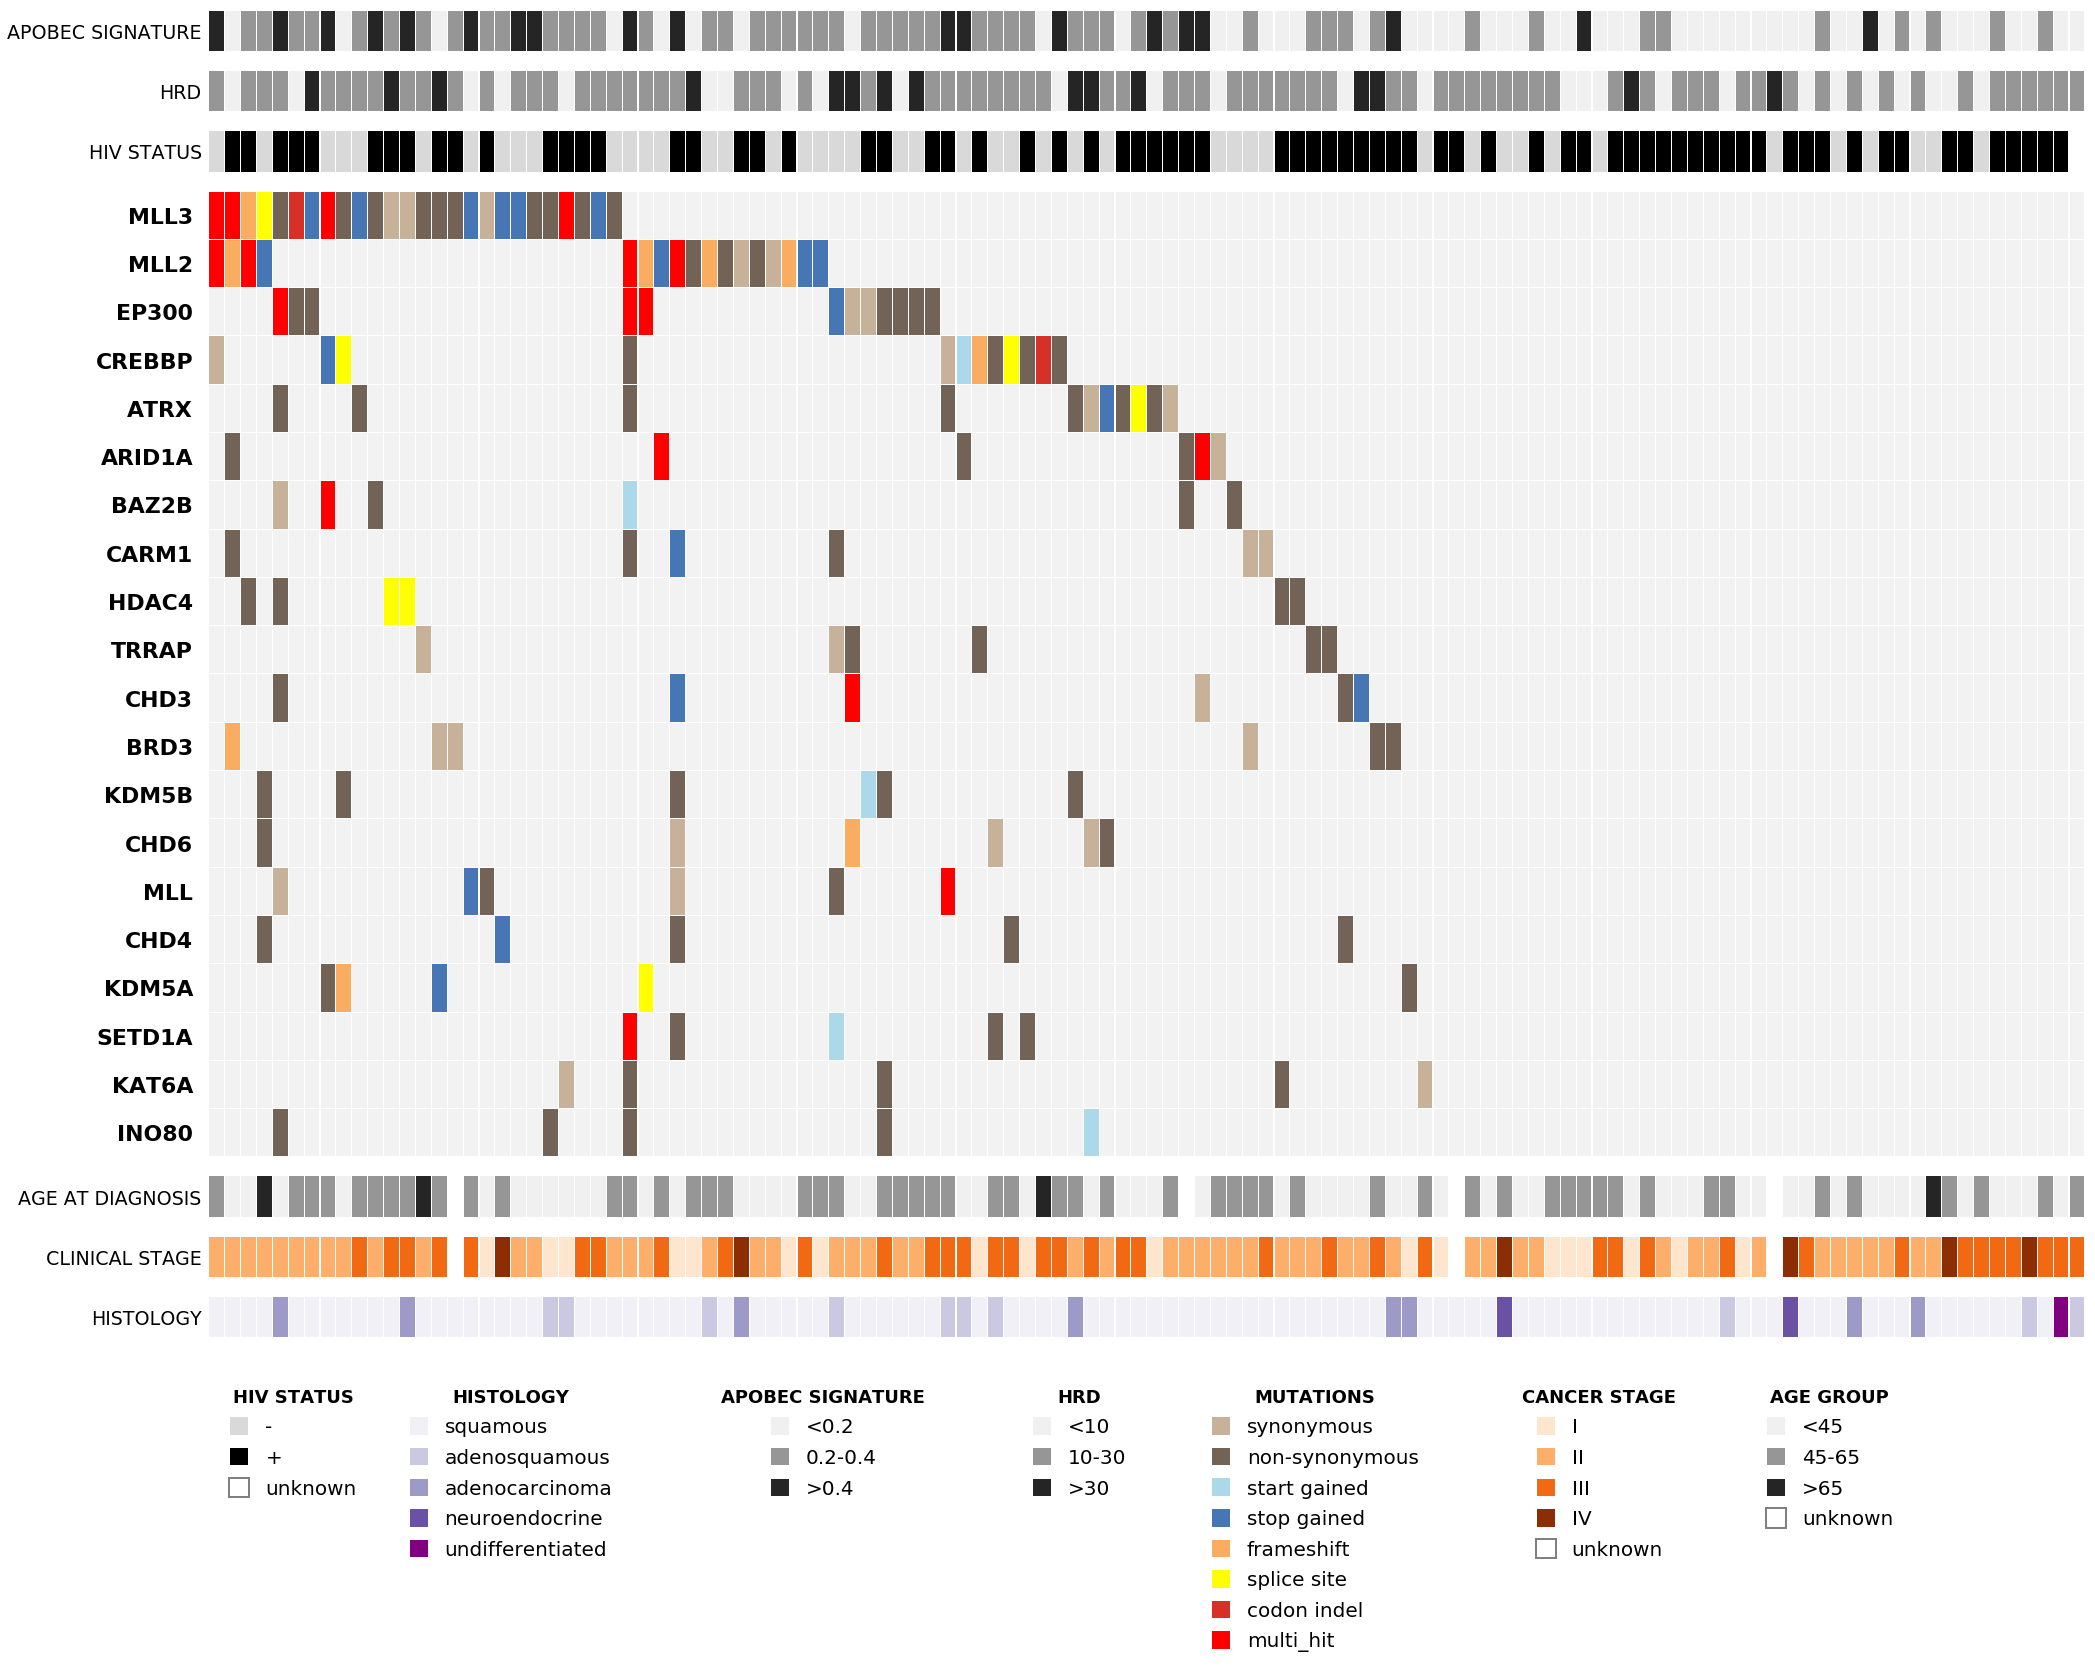

In [122]:
# inputs are 2 dataframes: mutation matrix and covariate matrix    
nrows = df7.shape[0]    
fig = plt.figure(figsize=(36,.85*nrows*2), facecolor='white')


gs = gridspec.GridSpec(9, 5,                            
                       width_ratios=[.3,.26,15,.2,.3], 
                       height_ratios=[3,0.6,0.6,0.6,14,0.6,0.6, 0.6,4],
                       wspace=0, # horizontal space
                       hspace=0.1  # vertical space
                      )


patients = sorted_pats
histology = ['Adenocarcinoma', 'Squamous', 'Neuroendocrine', 'Adenosquamous', 'Undifferentiated']
HIV_status = ['Negative', 'Positive', 'unknown']

# patients = [p for p in df.columns.tolist() if p.startswith('HTMCP')]
# dfa plot the heatmap of different types of mutations

mutations = ['Non-synonymous', 
             'Codon indel', 
             'Frameshift',              
             'Splice site', 
             'Stop gained',
             'Start gained',
             'Synonymous',
             'Multi_hit']
# tumor_grades = ['G1', 'G2', 'G3','unknown']
stages = ['Stage I',  'Stage II', 'Stage III', 'Stage IV', 'unknown']
ages = ['<45', '45-65', '>65', 'unknown']
hrds = ['<=10', '10-30', '>30']
apobec = ['>0.4', '<0.2', '0.2-0.4']


# add in molecular covariate track
map_dict_cov, cmap_cov = make_cmap_for_heatmap(apobec, color_dict)

df_apobec = df_cov.loc[['APOBEC_signature'],:]
ax7 = plt.subplot(gs[7], facecolor='white')
df_apobecrt = plot_covariate_track(ax7, df_apobec, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(hrds, color_dict)
df_hrd = df_cov.loc[['HRD'],:]
ax12 = plt.subplot(gs[12], facecolor='white')
df_hrdrt = plot_covariate_track(ax12, df_hrd, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(HIV_status, color_dict)
df_hiv = df_cov.loc[['HIV_status'],:]
# print(df_hiv)
ax17 = plt.subplot(gs[17], facecolor='white')
df_hivrt = plot_covariate_track(ax17, df_hiv, patients, map_dict_cov, cmap_cov)

# plot heatmap for gene mutations
# make map dictionary to map types to a number so that heatmap can plot
map_dict, cmap = make_cmap_for_heatmap(mutations, color_dict)
ax22 = plt.subplot(gs[22], facecolor='beige')
df_mutheatmap = plot_mutation_heatmap(ax22, df7, map_dict, cmap)

# add in clinical covariate tracks
map_dict_cov, cmap_cov = make_cmap_for_heatmap(ages, color_dict)
df_age = df_cov.loc[['Age_at_diagnosis'],:]
ax27 = plt.subplot(gs[27], facecolor='white')
df_agert = plot_covariate_track(ax27, df_age, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(stages, color_dict)
df_stage = df_cov.loc[['Clinical_stage'],:]
ax32 = plt.subplot(gs[32], facecolor='white')
df_stagert = plot_covariate_track(ax32, df_stage, patients, map_dict_cov, cmap_cov)

map_dict_cov, cmap_cov = make_cmap_for_heatmap(histology, color_dict)
df_histo = df_cov.loc[['Histology'],:]
ax37 = plt.subplot(gs[37], facecolor='white')
df_histort = plot_covariate_track(ax37, df_histo, patients, map_dict_cov, cmap_cov)


# plot all legend
gs42 = gs[42]
ax42 =  plt.subplot(gs42, frameon=False)
# add subplots in an ax made by plt.subplots to accommodate legend panels
axxs = gridspec.GridSpecFromSubplotSpec(1,8 , subplot_spec=ax42, 
                                        width_ratios=[1,2,2,1,2,1.5,1.2,1], hspace=1)
leg_titles = ['HIV STATUS', 'HISTOLOGY', 'APOBEC SIGNATURE', 'HRD',
             'MUTATIONS', 'CANCER STAGE', 'AGE GROUP']#, 'COPY NUMBER']
leg_patches = [hiv_patches, histology_patches, apobec_patches, hrd_patches,
               mut_patches, stage_patches, age_patches]#, cn_circles]
for i, (ltitle, lpatches) in enumerate(zip(leg_titles, leg_patches)):
    axx = plt.subplot(axxs[i], frame_on=False)
    add_legend(axx, lpatches, ltitle)



# a few checks to make sure patient order is consistent. 
# in theory this one check should suffice
assert (df_mutheatmap.columns == df_cov.columns).all

# mutation heatmap and covariate track
assert (df_mutheatmap.columns == df_apobec.columns).all()
# mutation heatmap and molecular covariate track
assert (df_mutheatmap.columns == df_hrd.columns).all()
# mutation heatmap and copy number overlay
assert (df_mutheatmap.columns == df_hiv.columns).all()

assert (df_mutheatmap.columns == df_age.columns).all()
# mutation heatmap and molecular covariate track
assert (df_mutheatmap.columns == df_stage.columns).all()
# mutation heatmap and copy number overlay
assert (df_mutheatmap.columns == df_histo.columns).all()
assert (patients == df_mutheatmap.columns).all()
pdf = '/projects/trans_scratch/validations/workspace/szong/Cervical/epigenetics/top20_epigenetic_genes_oncoprint-20190611.pdf'
# %time plt.savefig(of, bbox_inches='tight',dpi=200)
plt.savefig(pdf,bbox_inches='tight',dpi=300)
plt.show()